# Analysis of how mentions of a stock on WSB relates to stock prices

WallStreetBets is a popular forum on reddit known for going to the moon, apes and stonks. Jokes aside, despite all of the ridiculous bad trades, undecipherable jargon and love for memes, it's effect on the stock market is undeniable. Therefore in this project, we want to investigate how the reaction of reddit users on the forum relate to actual changes in the stock market.


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import os 
import tensorflow as tf

from datetime import datetime
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reddit Post Data

Source: https://huggingface.co/datasets/SocialGrep/reddit-wallstreetbets-aug-2021


In [ ]:
# TODO: add shortcut from shared drive for:
#   wsb-aug-2021-comments.csv

def load_data(filename, path="/content/drive/MyDrive/"):
    # read csv file and drop indices 
    df = pd.read_csv(os.path.join(path, filename))
    df = df.dropna(axis=0)
    # convert utc to datetime format 
    df["date"] = pd.to_datetime(df["created_utc"],unit="s").dt.date
    return df 

filename = "wsb-aug-2021-comments.csv"
df = load_data(filename)

#### Overal Sentiment on the Subreddit

In [ ]:
def sentiment_bins(df):
    
    # extract sentiment 
    sent_df = df[["date","sentiment"]]
    bins = {} 
    bins["positive"] = sent_df.loc[sent_df["sentiment"] > 0.25,:]
    bins["negative"] = sent_df.loc[sent_df["sentiment"] < -0.25,:]
    bins["neutral"] = sent_df.loc[sent_df["sentiment"].between(-0.25,0.25),:]
    
    # count the posts in each bin for each day 
    for name in bins:
        bins[name] = bins[name].groupby(['date']).count()
    counts = sent_df.groupby(['date']).count()
    return bins, counts 

def plot_sentiment(df,normalize=True, title=None):

    # collect sentiment into three bins 
    bins, counts = sentiment_bins(df)

    # plot counts of each bin every day 
    colours = ["lightgreen", "coral", "grey"]
    for i, name in enumerate(["positive", "negative", "neutral"]):
        dates = bins[name].index 
        total_counts = counts.loc[dates,:].values.reshape(-1)
        bin_counts = bins[name]["sentiment"].values
        if not normalize: 
            total_counts = 1 
        plt.plot(dates, bin_counts / total_counts, 
                 alpha=0.7, c=colours[i])
    
    plt.legend(["positive", "negative", "neutral"])
    if title:
        plt.title(title)
    plt.xticks(rotation=20)
    plt.show() 

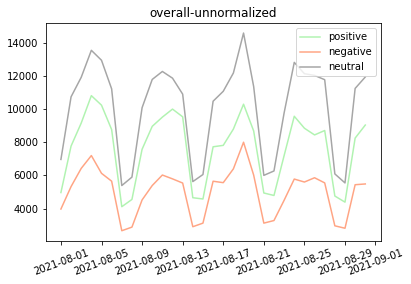

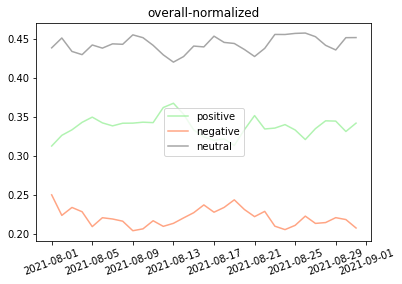

In [ ]:
plot_sentiment(df,normalize=False, title="overall-unnormalized")
plot_sentiment(df,normalize=True, title="overall-normalized")

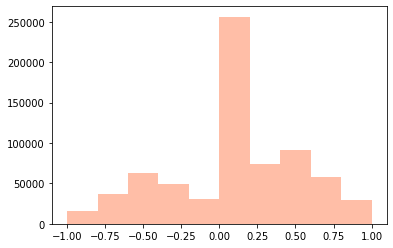

In [ ]:
# distribution of sentiment of the posts 
plt.hist(df["sentiment"], color="coral", 
         alpha=0.5)
plt.show()

#### Sentiment for individual stocks

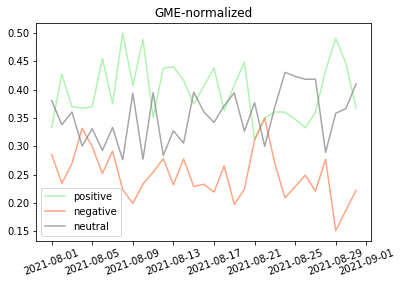

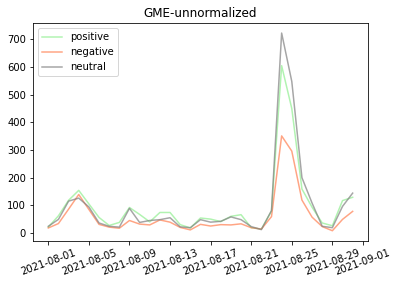

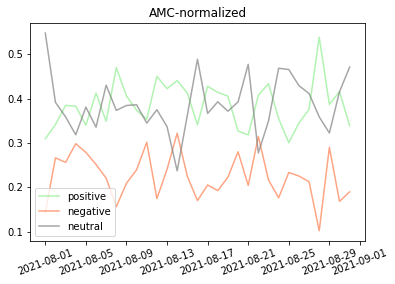

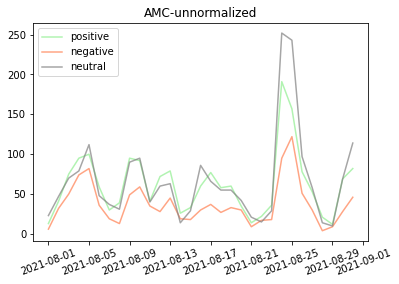

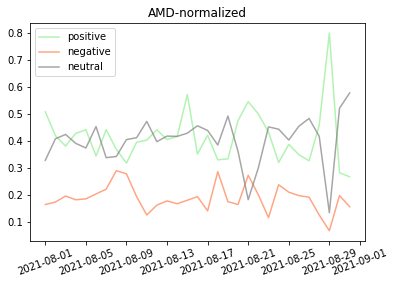

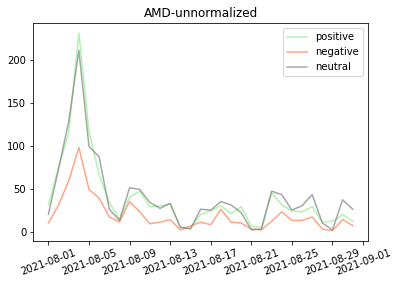

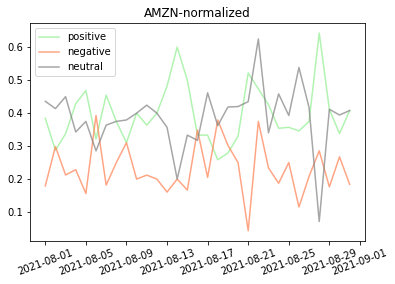

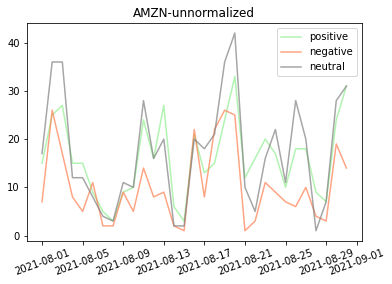

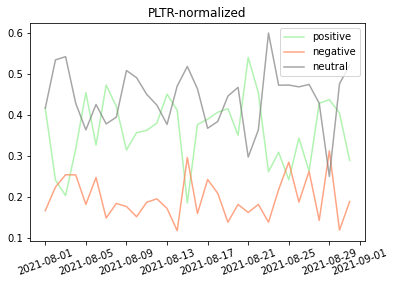

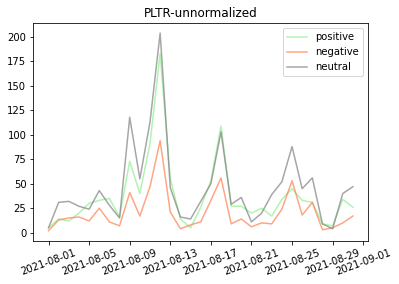

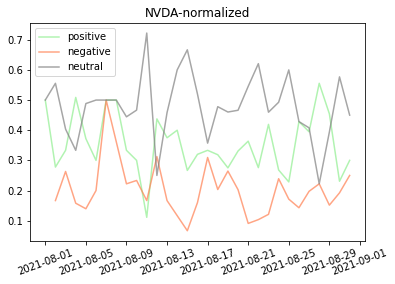

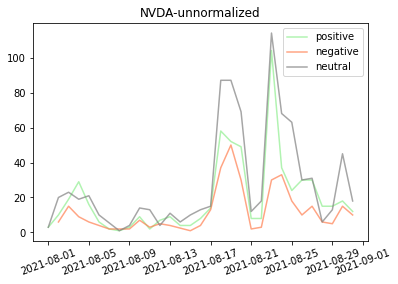

In [ ]:
stocks = ["GME", "AMC", "AMD","AMZN", "PLTR", "NVDA"]
for stock in stocks:
    gme_posts = df.loc[df["body"].str.contains(stock),:] 
    plot_sentiment(gme_posts,title=f"{stock}-normalized", normalize=True)
    plot_sentiment(gme_posts,title=f"{stock}-unnormalized", normalize=False)

### Analyzing Stock Data 

In [ ]:
def get_daily_sentiment(df, stock):

    # intialize df with all dates in august 
    datelist = pd.date_range(datetime(2021,8,1), periods=31).tolist()
    sentiment_df = pd.DataFrame({"date":datelist})
    sentiment_df = sentiment_df.set_index("date")
    
    # get all posts mentioning stock 
    posts = df.loc[df["body"].str.contains(stock),:]
    bins, counts = sentiment_bins(posts)

    # get number of posts in each bin 
    for name,values in bins.items():
        values = values 
        values.index = pd.to_datetime(values.index)
        values = values.rename(columns={"sentiment":name})
        sentiment_df = sentiment_df.join(values)

    # get the total number of posts for each day 
    counts.index = pd.to_datetime(counts.index)
    counts = counts.rename(columns={"sentiment":"count"})

    sentiment_df = sentiment_df.join(counts)
    sentiment_df = sentiment_df.fillna(0)
    return sentiment_df

def load_stocks(filename="drive/MyDrive/Stock Prices.csv"):

    stonks = pd.read_csv(filename)

    # add missing dates to df 
    stonks.Date = pd.to_datetime(stonks.Date)
    datelist = pd.date_range(datetime(2021,8,1), periods=31).tolist()
    dates = pd.DataFrame({"Date":datelist})
    stonks_df = pd.merge(dates, stonks, on="Date", how="left")

    # fill the null values using closest date
    stonks_df = stonks_df.interpolate(method='nearest')
    stonks_df = stonks_df.set_index('Date')
    return stonks_df

In [ ]:
# we identified the forum's favourite stocks 
stocks = ["GME", "AMC", "AMD","AMZN", "PLTR", "NVDA"]

# retrieve the sentiment informationn for each stock 
sentiment_df = {stock: get_daily_sentiment(df, stock) for stock in stocks}
stonks_df = load_stocks() 

#### visualize stock prices 

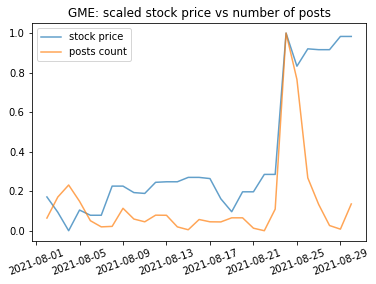

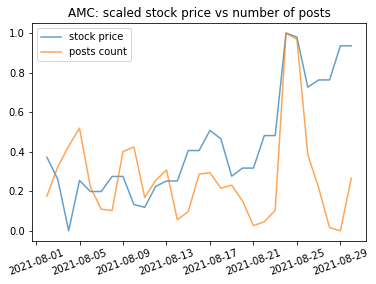

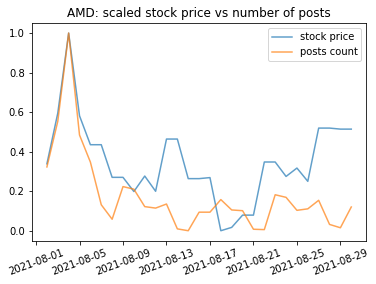

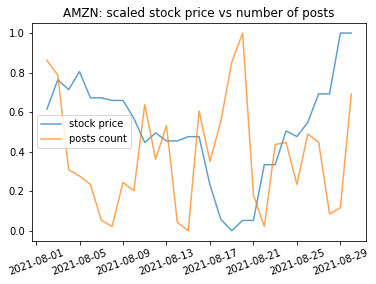

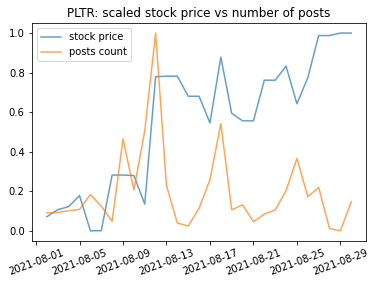

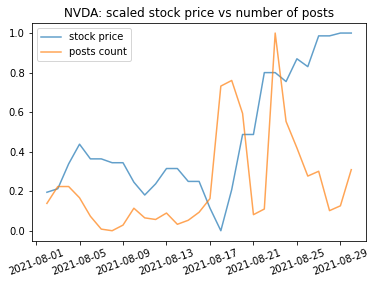

In [ ]:
def scale(x):
    minx = np.min(x); maxx = np.max(x)
    return (x-minx) / (maxx-minx)

for stock in stocks:
    # plot scaled price against the number of posts
    price = stonks_df.dropna(axis=0)[[stock]]
    num_posts = sentiment_df[stock]["count"].loc[price.index,].values
    plt.plot(price.index, scale(price), alpha=0.7)
    plt.plot(price.index, scale(num_posts), alpha=0.7)
    plt.xticks(rotation=20)
    plt.title(f"{stock}: scaled stock price vs number of posts")
    plt.legend(["stock price", "posts count"])
    plt.show()

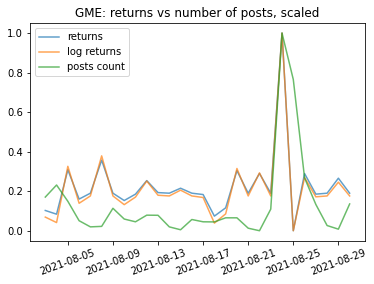

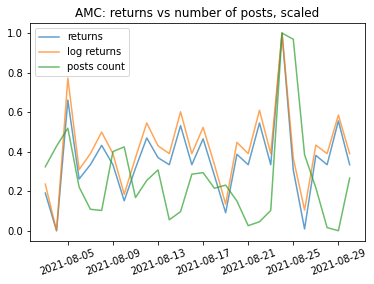

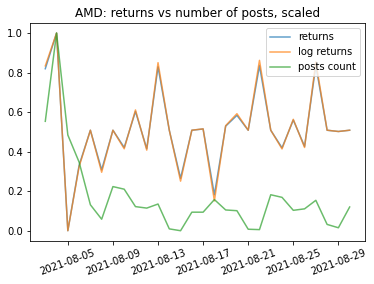

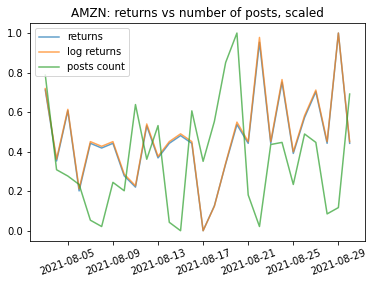

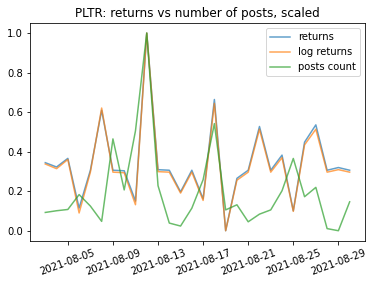

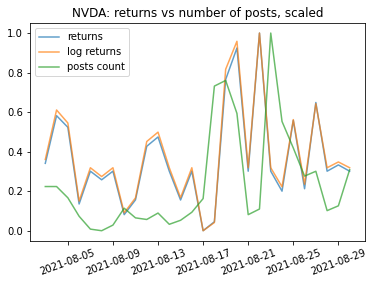

In [ ]:
stonks_log = np.log(stonks_df)
for stock in stocks:
    returns = stonks_df.diff().dropna(axis=0)[[stock]]
    log_returns = stonks_log.diff().dropna(axis=0)[[stock]]
    num_posts = sentiment_df[stock]["count"].loc[returns.index,].values
    plt.plot(returns.index, scale(returns), alpha=0.7)
    plt.plot(returns.index, scale(log_returns),alpha=0.7)
    plt.plot(returns.index, scale(num_posts),alpha=0.7)
    plt.xticks(rotation=20)
    plt.title(f"{stock}: returns vs number of posts, scaled")
    plt.legend(["returns", "log returns", "posts count"])
    plt.show()

#### sentiment vs stock prices

In [ ]:
# from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

for stock in stocks:

    # get stock prices 
    y = stonks_df.dropna(axis=0)[[stock]]
    print("="*50)
    print(f'name: {stock}, total:{sum(sentiment_df[stock]["count"])}')
    print("="*50)

    for col in sentiment_df[stock].columns:

        # fit a linear model using the number of posts in each bin 
        X = sentiment_df[stock][col].loc[y.index,].values
        X = sm.add_constant(X)
        mod = sm.OLS(y,X)
        res = mod.fit()
        print(f'{col}: {res.rsquared:.3f}, pval: {res.pvalues.x1:.3f}')

name: GME, total:7867
positive: 0.228, pval: 0.009
negative: 0.183, pval: 0.021
neutral: 0.252, pval: 0.006
count: 0.229, pval: 0.009
name: AMC, total:5130
positive: 0.068, pval: 0.170
negative: 0.024, pval: 0.423
neutral: 0.162, pval: 0.030
count: 0.096, pval: 0.102
name: AMD, total:3060
positive: 0.445, pval: 0.000
negative: 0.362, pval: 0.001
neutral: 0.415, pval: 0.000
count: 0.424, pval: 0.000
name: AMZN, total:1330
positive: 0.032, pval: 0.351
negative: 0.077, pval: 0.145
neutral: 0.064, pval: 0.187
count: 0.062, pval: 0.191
name: PLTR, total:3223
positive: 0.003, pval: 0.761
negative: 0.001, pval: 0.845
neutral: 0.000, pval: 0.939
count: 0.001, pval: 0.851
name: NVDA, total:1799
positive: 0.043, pval: 0.282
negative: 0.001, pval: 0.855
neutral: 0.033, pval: 0.348
count: 0.028, pval: 0.387


In [ ]:
norm_df = {}
for stock in sentiment_df:
    norm_df[stock] =  sentiment_df[stock].copy()
    for col in norm_df[stock].columns:
        if col != "count":
            norm_df[stock][col] = norm_df[stock][col]/ norm_df[stock]["count"]

In [ ]:
import statsmodels.api as sm

names = ["intercept"] + list(norm_df["GME"].columns)
for stock in stocks:

    # get stock prices 
    y = stonks_df.dropna(axis=0)[[stock]]
    print("="*50)
    print(f'name: {stock}, total:{sum(sentiment_df[stock]["count"])}')
    print("="*50)

    # fit a linear model using the number of posts in each bin 
    X = norm_df[stock].loc[y.index,:].values
    X = sm.add_constant(X)
    mod = sm.OLS(y,X)
    res = mod.fit()
    print(f'{"rsquared"}: {res.rsquared:.3f}')
    for name, pval in zip(names, res.pvalues):
        print(f'{name}: {pval:.3f}')

name: GME, total:7867
rsquared: 0.381
intercept: 0.000
positive: 0.111
negative: 0.100
neutral: 0.028
count: 0.056
name: AMC, total:5130
rsquared: 0.206
intercept: 0.000
positive: 0.178
negative: 0.371
neutral: 0.061
count: 0.229
name: AMD, total:3060
rsquared: 0.511
intercept: 0.000
positive: 0.000
negative: 0.003
neutral: 0.000
count: 0.000
name: AMZN, total:1330
rsquared: 0.081
intercept: 0.000
positive: 0.000
negative: 0.000
neutral: 0.000
count: 0.313
name: PLTR, total:3223
rsquared: 0.021
intercept: 0.000
positive: 0.001
negative: 0.135
neutral: 0.054
count: 0.822
name: NVDA, total:1799
rsquared: 0.104
intercept: 0.000
positive: 0.000
negative: 0.117
neutral: 0.000
count: 0.278


#### sentiment vs stock direction 

In [ ]:
from sklearn.metrics import roc_auc_score

stonks_diff = stonks_df.diff()
for stock in stocks:

    # check if stock increased 
    y = (stonks_diff.dropna(axis=0)[[stock]] > 0) * 1
    print("="*50)
    print(f'name: {stock}, total:{sum(sentiment_df[stock]["count"])}')
    print("="*50)

    for col in sentiment_df[stock].columns:

        # fit a linear model using the number of posts in each bin 
        X = sentiment_df[stock][col].loc[y.index,].values
        X = sm.add_constant(X)
        log_reg = sm.Logit(y, X).fit(disp=False)
        ypred = log_reg.predict(X)
        score = roc_auc_score(y.values, ypred)
        acc = np.mean((ypred > 0.5) == y.values)
        print(f'{col}: auc:{score:.3f}, acc:{acc:.3f}')


name: GME, total:7867
positive: auc:0.478, acc:0.622
negative: auc:0.461, acc:0.633
neutral: auc:0.428, acc:0.622
count: auc:0.475, acc:0.622
name: AMC, total:5130
positive: auc:0.481, acc:0.607
negative: auc:0.553, acc:0.607
neutral: auc:0.548, acc:0.607
count: auc:0.548, acc:0.607
name: AMD, total:3060
positive: auc:0.564, acc:0.612
negative: auc:0.508, acc:0.622
neutral: auc:0.550, acc:0.612
count: auc:0.536, acc:0.612
name: AMZN, total:1330
positive: auc:0.544, acc:0.643
negative: auc:0.556, acc:0.643
neutral: auc:0.606, acc:0.612
count: auc:0.531, acc:0.643
name: PLTR, total:3223
positive: auc:0.497, acc:0.551
negative: auc:0.612, acc:0.546
neutral: auc:0.513, acc:0.566
count: auc:0.516, acc:0.551
name: NVDA, total:1799
positive: auc:0.698, acc:0.599
negative: auc:0.671, acc:0.569
neutral: auc:0.663, acc:0.599
count: auc:0.684, acc:0.584


In [ ]:
from sklearn.metrics import roc_auc_score

names = ["intercept"] + list(norm_df["GME"].columns)
stonks_diff = stonks_df.diff()
for stock in stocks:

    # get stock prices 
    y = (stonks_diff.dropna(axis=0)[[stock]] > 0) * 1
    print("="*50)
    print(f'name: {stock}, total:{sum(sentiment_df[stock]["count"])}')
    print("="*50)

    # fit a linear model using the number of posts in each bin 
    X = norm_df[stock].loc[y.index,:].values
    X = sm.add_constant(X)
    log_reg = sm.Logit(y, X).fit(disp=False)
    ypred = log_reg.predict(X)
    score = roc_auc_score(y.values, ypred)
    acc = np.mean((ypred > 0.5) == y.values)
    print(f'{col}: auc:{score:.3f}, acc:{acc:.3f}')

name: GME, total:7867
count: auc:0.639, acc:0.612
name: AMC, total:5130
count: auc:0.561, acc:0.592
name: AMD, total:3060
count: auc:0.644, acc:0.612
name: AMZN, total:1330
count: auc:0.839, acc:0.571
name: PLTR, total:3223
count: auc:0.740, acc:0.515
name: NVDA, total:1799
count: auc:0.626, acc:0.584


#### sentiment vs returns

In [ ]:
stonks_diff = stonks_df.diff()
for stock in stocks:
    y = stonks_diff.dropna(axis=0)[[stock]]
    print("="*50)
    print(f'name: {stock}')
    print("="*50)
    for col in sentiment_df[stock].columns:
        X = sentiment_df[stock][col].loc[y.index,].values
        X = sm.add_constant(X)
        mod = sm.OLS(y,X)
        res = mod.fit()
        print(f'{col}: {res.rsquared:.3f},  pval: {res.pvalues.x1:.3f}')

name: GME
positive: 0.297,  pval: 0.003
negative: 0.220,  pval: 0.012
neutral: 0.298,  pval: 0.003
count: 0.282,  pval: 0.004
name: AMC
positive: 0.047,  pval: 0.270
negative: 0.006,  pval: 0.706
neutral: 0.070,  pval: 0.175
count: 0.045,  pval: 0.280
name: AMD
positive: 0.076,  pval: 0.157
negative: 0.051,  pval: 0.247
neutral: 0.086,  pval: 0.130
count: 0.076,  pval: 0.157
name: AMZN
positive: 0.013,  pval: 0.562
negative: 0.055,  pval: 0.229
neutral: 0.002,  pval: 0.806
count: 0.016,  pval: 0.520
name: PLTR
positive: 0.299,  pval: 0.003
negative: 0.206,  pval: 0.015
neutral: 0.206,  pval: 0.015
count: 0.247,  pval: 0.007
name: NVDA
positive: 0.029,  pval: 0.388
negative: 0.045,  pval: 0.276
neutral: 0.040,  pval: 0.311
count: 0.039,  pval: 0.312


In [ ]:
# incorporate the sentiment for each day as well 
names = ["intercept"] + list(norm_df["GME"].columns)
stonks_diff = stonks_df.diff()
for stock in stocks:

    # get stock prices 
    y = stonks_diff.dropna(axis=0)[[stock]]
    print("="*50)
    print(f'name: {stock}, total:{sum(sentiment_df[stock]["count"])}')
    print("="*50)

    # fit a linear model using the number of posts in each bin 
    X = norm_df[stock].loc[y.index,:].values
    X = sm.add_constant(X)
    mod = sm.OLS(y,X)
    res = mod.fit()
    print(f'{"rsquared"}: {res.rsquared:.3f}')
    for name, pval in zip(names, res.pvalues):
        print(f'{name}: {pval:.3f}')

name: GME, total:7867
rsquared: 0.314
intercept: 0.271
positive: 0.314
negative: 0.761
neutral: 0.503
count: 0.005
name: AMC, total:5130
rsquared: 0.059
intercept: 0.453
positive: 0.603
negative: 0.601
neutral: 0.885
count: 0.291
name: AMD, total:3060
rsquared: 0.082
intercept: 0.481
positive: 0.763
negative: 0.698
neutral: 0.903
count: 0.163
name: AMZN, total:1330
rsquared: 0.165
intercept: 0.770
positive: 0.436
negative: 0.251
neutral: 0.046
count: 0.308
name: PLTR, total:3223
rsquared: 0.284
intercept: 0.531
positive: 0.355
negative: 0.895
neutral: 0.466
count: 0.007
name: NVDA, total:1799
rsquared: 0.049
intercept: 0.855
positive: 0.642
negative: 0.634
neutral: 0.981
count: 0.300


#### sentiment vs log returns 

In [ ]:
stonks_log = np.log(stonks_df)
for stock in stocks:
    y = stonks_log.diff().dropna(axis=0)[[stock]]
    print("="*50)
    print(f'name: {stock}')
    print("="*50)
    for col in sentiment_df[stock].columns:
        X = sentiment_df[stock][col].loc[y.index,].values
        X = sm.add_constant(X)
        mod = sm.OLS(y,X)
        res = mod.fit()
        print(f'{col}: {res.rsquared:.3f},  pval: {res.pvalues.x1:.3f}')

name: GME
positive: 0.287,  pval: 0.003
negative: 0.212,  pval: 0.014
neutral: 0.289,  pval: 0.003
count: 0.272,  pval: 0.004
name: AMC
positive: 0.035,  pval: 0.341
negative: 0.003,  pval: 0.775
neutral: 0.057,  pval: 0.219
count: 0.035,  pval: 0.342
name: AMD
positive: 0.071,  pval: 0.171
negative: 0.047,  pval: 0.270
neutral: 0.081,  pval: 0.143
count: 0.071,  pval: 0.171
name: AMZN
positive: 0.014,  pval: 0.554
negative: 0.056,  pval: 0.225
neutral: 0.003,  pval: 0.797
count: 0.017,  pval: 0.512
name: PLTR
positive: 0.294,  pval: 0.003
negative: 0.202,  pval: 0.016
neutral: 0.202,  pval: 0.016
count: 0.243,  pval: 0.008
name: NVDA
positive: 0.031,  pval: 0.372
negative: 0.050,  pval: 0.253
neutral: 0.041,  pval: 0.300
count: 0.042,  pval: 0.297


The 

### Further Areas of Interest 